In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET
import pandas as pd
import glob
import imgaug as ia
ia.seed(4)
import imgaug.augmenters as iaa
import imgaug as ia  ## ImageAug library
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

## Function to convert all xml files into one CSV file

In [ ]:
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
os.chdir('/content/drive/MyDrive')
!pwd

/content/drive/MyDrive


In [ ]:
path = '/content/drive/MyDrive/segmentedAnnotated/segmented'
labels_df = xml_to_csv(path)
labels_df.to_csv(('labels.csv'), index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


In [ ]:
labels_df = pd.read_csv('/content/drive/MyDrive/labels.csv')

In [ ]:
labels_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,18.png,560,284,seatbelt,226,132,279,168
1,17.png,1200,627,seatbelt,527,410,680,617
2,16.png,752,501,seatbelt,301,225,470,271
3,15.png,1000,1000,seatbelt,414,503,619,729
4,14.png,640,427,seatbelt,280,221,343,313


## Displaying bounding box on image

In [ ]:
grouped = labels_df.groupby('filename')
group_df = grouped.get_group('24.png')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
group_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,24.png,940,466,seatbelt,471,249,596,350


In [ ]:
# get bounding boxes coordinates from grouped data frame and write into array
bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
# display the array we've got
bb_array

array([[471, 249, 596, 350]])

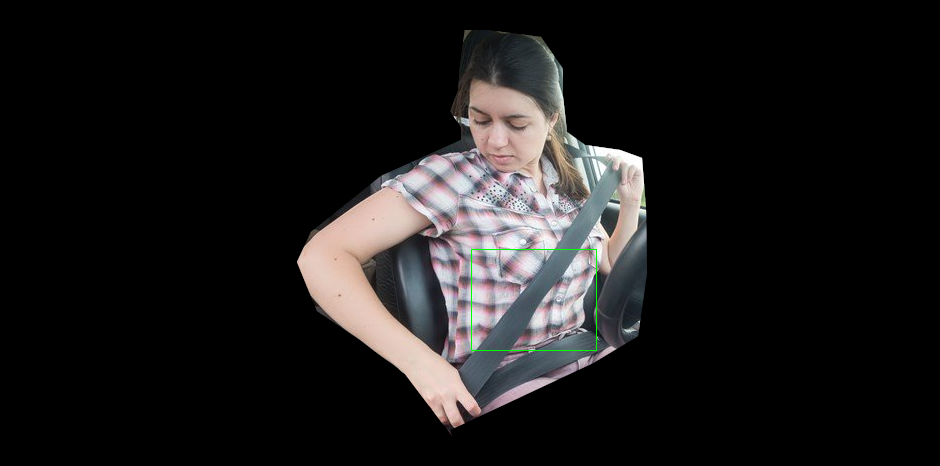

In [ ]:
image = cv2.imread('/content/drive/MyDrive/segmented/24.png', cv2.IMREAD_UNCHANGED)
# pass the array of bounding boxes coordinates to the imgaug library
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
# display the image and draw bounding boxes
cv2_imshow(bbs.draw_on_image(image[:,:,0:3], size=1))

In [ ]:
def getBB(BB_df, filename, image):
  grouped = BB_df.groupby('filename')
  group_df = grouped.get_group(filename)
  group_df = group_df.reset_index()
  group_df = group_df.drop(['index'], axis=1)

  bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
  bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)

  bb_x1 = bbs.bounding_boxes[0].x1
  bb_y1 = bbs.bounding_boxes[0].y1
  bb_x2 = bbs.bounding_boxes[0].x2
  bb_y2 = bbs.bounding_boxes[0].y2



  return bb_x1, bb_y1, bb_x2, bb_y2

In [ ]:
def displayBB(BB_df, filename, image):
  grouped = BB_df.groupby('filename')
  group_df = grouped.get_group(filename)
  group_df = group_df.reset_index()
  group_df = group_df.drop(['index'], axis=1)

  bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
  bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
# display the image and draw bounding boxes
  cv2_imshow(bbs.draw_on_image(image, size=1))

## Augment the image

Augmented:


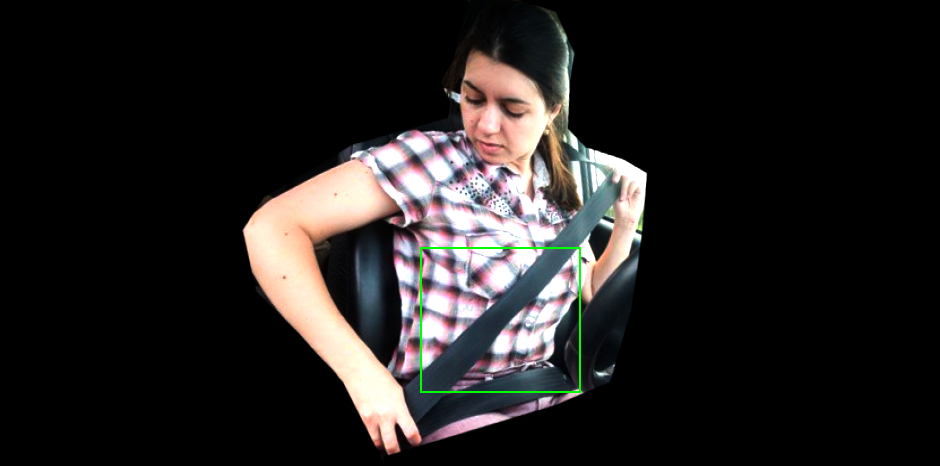

In [ ]:
seq = iaa.Sequential([
    iaa.Affine(rotate=(-25, 25)),
    iaa.CropAndPad(percent=(-0.2, 0.2), pad_mode="edge"),  # crop and pad images
    iaa.GammaContrast((0.5, 2.0)),
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
])
image_aug, bbs_aug= seq(image=image, bounding_boxes = bbs)

print("Augmented:")
cv2_imshow(bbs_aug.draw_on_image(image_aug[:,:,0:3], size=2))

## Select a background

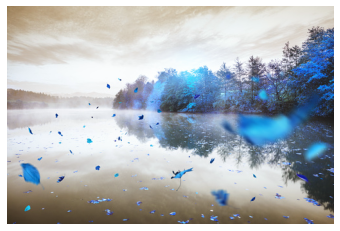

In [ ]:
# Random selection of background from the folder
background = cv2.imread('/content/drive/MyDrive/background/flying-autumn-leaves-picture-id1262572653.jpg')
# Visualize the background
plt.imshow(background)
plt.axis('off')
plt.show()


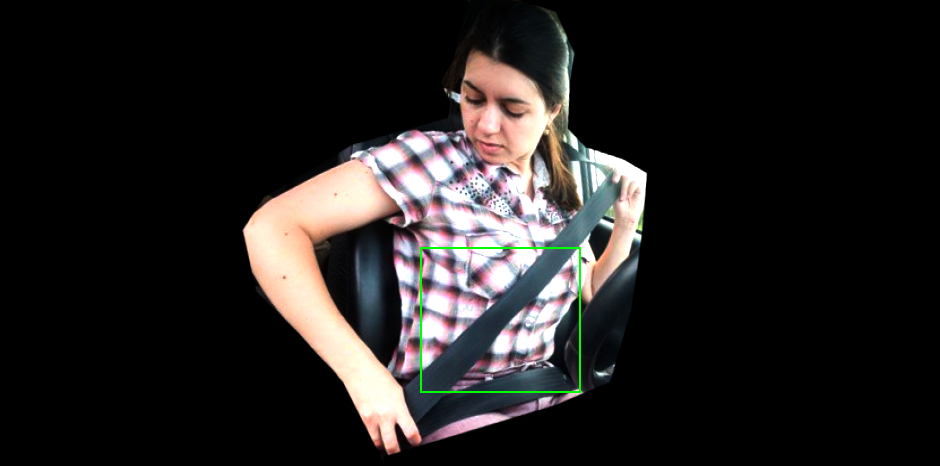

In [ ]:
cv2_imshow(bbs_aug.draw_on_image(image_aug[:,:,0:3], size=2))

In [ ]:
bbs

BoundingBoxesOnImage([BoundingBox(x1=471.0000, y1=249.0000, x2=596.0000, y2=350.0000, label=None)], shape=(466, 940, 4))

In [ ]:
bbs_aug

BoundingBoxesOnImage([BoundingBox(x1=304.7803, y1=119.5739, x2=385.9160, y2=219.4875, label=None)], shape=(433, 575, 3))

### Coordinates of the BB

In [ ]:
bbs_aug.bounding_boxes[0].x1

304.78027

### Height

In [ ]:
bbs_aug.shape[0]

433

## Image augmentation function

In [ ]:
def augment_foreground(df, filename, image):
  seq = iaa.Sequential([
      iaa.Affine(rotate=(-25, 25)),
      iaa.CropAndPad(percent=(-0.2, 0.2), pad_mode="edge"),  # crop and pad images
      iaa.GammaContrast((0.5, 2.5)),
      iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
  ])
  x1, y1, x2, y2 = getBB(df, filename, image)
  image_aug, bbs_aug= seq(image=image, bounding_boxes = BoundingBoxesOnImage([BoundingBox(x1, y1, x2, y2)],
                                                                             shape=image.shape))

  return image_aug, bbs_aug

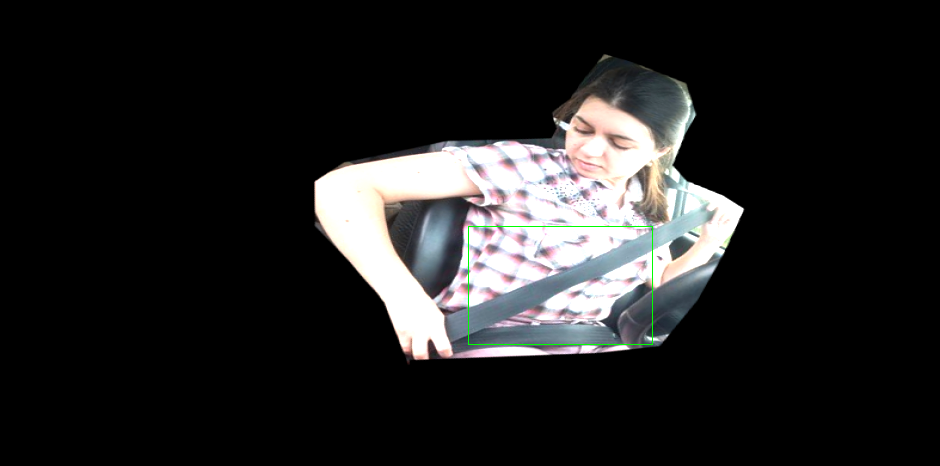

In [ ]:
image_aug, bbs_aug = augment_foreground(labels_df, '24.png',image)
cv2_imshow(bbs_aug.draw_on_image(image_aug[:,:,0:3], size = 1))

## Background + Foreground

In [ ]:
def combine_two_images(foreground, background):

    mask = np.where(foreground[:,:,0]>0, 255, 0) / 255
    background = cv2.resize(background, (foreground.shape[1], foreground.shape[0]))

    # Subtract the foreground area from the background
    background = background*(1 - mask.reshape(foreground.shape[0], foreground.shape[1], 1))

    # Finally, add the foreground
    composed_image = background + foreground

    return composed_image

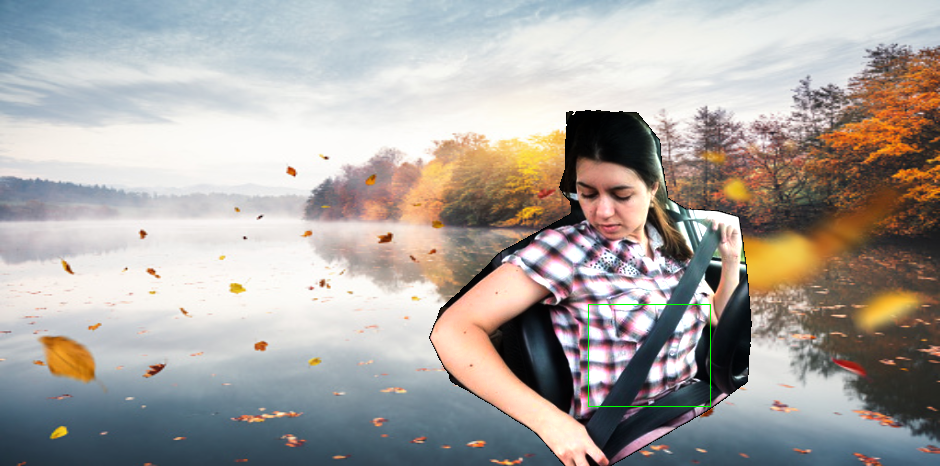

In [ ]:
new_image = combine_two_images(image_aug[:,:,0:3], background)
cv2_imshow(bbs_aug.draw_on_image(new_image, size = 1))

## Create a dataframe of annotations



*   Loop over the images in segmented folder
*   os.path.basename sai filenam extract
*   image augment kro
*   compose the two images
* find their bounding boxes
* list mai append kro new BBs ko
* convert it into df



In [ ]:
def syntheticImageGenerator(labels_df, foregrounds, backgrounds, output_path):

  count = 0

  bb_list = []  ## List to store bounding boxes of augmented images

  for fg_image in glob.glob(foregrounds + "*.png"):
    fg = cv2.imread(fg_image, cv2.IMREAD_UNCHANGED)
    image_name = os.path.basename(fg_image)  ## get the filename

    for bg_image in glob.glob(background + "*.jpg"):
      bg = cv2.imread(bg_image, cv2.IMREAD_UNCHANGED)
      image_aug, bb_aug = augment_foreground(labels_df, image_name, fg[:,:,0:3])  ## Augmenting the png foreground

      new_image = combine_two_images(image_aug, bg)  ## Combining the two images

      bb_coordinates = bb_aug.bounding_boxes[0]  ## consists of x1, y1, x2, y2

      bb_shape = bb_aug.shape  ## consists of height and width

      final_filename = 'file'+str(count)+'.jpg'
      bb_list.append([final_filename ,bb_shape[1], bb_shape[0], 'seatbelt',
                      bb_coordinates.x1, bb_coordinates.y1, bb_coordinates.x2, bb_coordinates.y2])  ## Appending the filename, width,
                                                                                                    ## height, class name, x1, y1, x2 and y2
      cv2.imwrite(os.path.join(output_path, final_filename), new_image)
      print(str(count)+ " pictures uploaded")
      count += 1 #increamenting count

  column_names = ['filename',	'width',	'height',	'class',	'xmin',	'ymin',	'xmax',	'ymax'] ## column name same as in the original df
  bb_df = pd.DataFrame(bb_list, columns= column_names)

  return bb_df


# TRY MARO YAR

In [ ]:
foreground = '/content/drive/MyDrive/se/'
background = '/content/drive/MyDrive/bg/'
output_path = '/content/drive/MyDrive/check/'
bbl = syntheticImageGenerator(labels_df,foreground, background, output_path)

0 pictures uploaded
1 pictures uploaded
2 pictures uploaded
3 pictures uploaded
4 pictures uploaded
5 pictures uploaded
6 pictures uploaded
7 pictures uploaded
8 pictures uploaded
9 pictures uploaded
10 pictures uploaded
11 pictures uploaded
12 pictures uploaded
13 pictures uploaded
14 pictures uploaded
15 pictures uploaded


In [ ]:
bbl

,filename,width,height,class,xmin,ymin,xmax,ymax
0,file0.jpg,1860,1050,seatbelt,1311.130005,278.761993,1748.316528,777.667358
1,file1.jpg,1860,1050,seatbelt,1547.997925,497.044739,2185.038818,879.368347
2,file2.jpg,1860,1050,seatbelt,1123.414551,161.994965,1555.287598,564.790405
3,file3.jpg,1860,1050,seatbelt,1744.908813,393.488190,2155.570312,687.023621
4,file4.jpg,940,466,seatbelt,521.532043,187.816635,678.252441,355.357117
5,file5.jpg,940,466,seatbelt,388.521271,285.314270,529.457214,435.047546
6,file6.jpg,940,466,seatbelt,452.686981,241.847336,612.427368,357.678955
7,file7.jpg,940,466,seatbelt,413.286102,297.522308,549.813293,442.841156
8,file8.jpg,560,284,seatbelt,257.983521,168.741226,372.444031,297.677612
9,file9.jpg,560,284,seatbelt,220.122406,179.605179,295.079773,300.646759


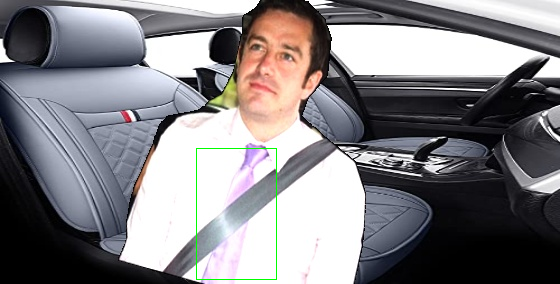

In [ ]:
image = cv2.imread('/content/drive/MyDrive/check/file10.jpg')
displayBB(bbl, 'file10.jpg', image)

In [ ]:
foreground = '/content/drive/MyDrive/segmented/'
background = '/content/drive/MyDrive/backgroundOG/'
output_path = '/content/drive/MyDrive/smhData/'
bb_final_df = syntheticImageGenerator(labels_df,foreground, background, output_path)

Streaming output truncated to the last 5000 lines.
4310 pictures uploaded
4311 pictures uploaded
4312 pictures uploaded
4313 pictures uploaded
4314 pictures uploaded
4315 pictures uploaded
4316 pictures uploaded
4317 pictures uploaded
4318 pictures uploaded
4319 pictures uploaded
4320 pictures uploaded
4321 pictures uploaded
4322 pictures uploaded
4323 pictures uploaded
4324 pictures uploaded
4325 pictures uploaded
4326 pictures uploaded
4327 pictures uploaded
4328 pictures uploaded
4329 pictures uploaded
4330 pictures uploaded
4331 pictures uploaded
4332 pictures uploaded
4333 pictures uploaded
4334 pictures uploaded
4335 pictures uploaded
4336 pictures uploaded
4337 pictures uploaded
4338 pictures uploaded
4339 pictures uploaded
4340 pictures uploaded
4341 pictures uploaded
4342 pictures uploaded
4343 pictures uploaded
4344 pictures uploaded
4345 pictures uploaded
4346 pictures uploaded
4347 pictures uploaded
4348 pictures uploaded
4349 pictures uploaded
4350 pictures uploaded
4351 p

In [ ]:
bb_final_df.shape

(9310, 8)

In [ ]:
os.chdir('/content/drive/MyDrive')
!pwd

/content/drive/MyDrive


In [ ]:
bb_final_df.to_csv(('bb_df.csv'), index=None)
print('Successfully converted df to csv.')

Successfully converted df to csv.


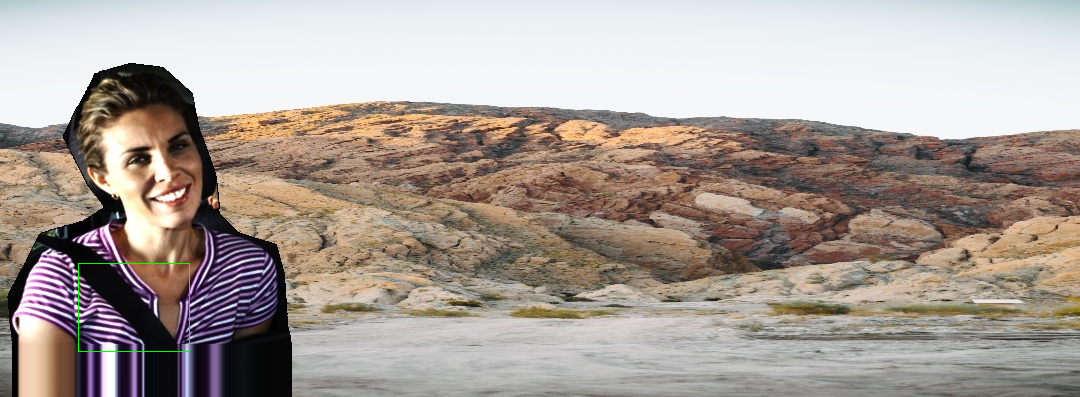

In [ ]:
im = cv2.imread('/content/drive/MyDrive/smhData/file5520.jpg', cv2.IMREAD_UNCHANGED)
displayBB(bb_final_df, 'file5520.jpg',im)

In [ ]:
import glob

def generate(foregrounds, backgrounds, path):
  count = 0
  for fg in glob.glob(foregrounds + "*.png"):
    fgImage = cv2.imread(fg)  #reading image

    for bg in glob.glob(backgrounds + "*.jpg"):
      bgImage = cv2.imread(bg)
      foreground_new = foregroundAug(fgImage)  #augmenting
      mask_new = getForegroundMask(foreground_new) #masking the segmented image
      composed_image = compose(foreground_new, mask_new, bgImage)  #incorporating foreground and background
      composed_image = cv2.normalize(composed_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_32F)

      cv2.imwrite(os.path.join(path, 'file'+str(count)+'.jpg'), composed_image)
      print("hogaya")
      count += 1 #increamenting count

In [ ]:
f = '/content/drive/MyDrive/segmented/'
b = '/content/drive/MyDrive/background/'

In [ ]:
path = os.getcwd()

In [ ]:
path

'/content/drive/MyDrive/finalDataGen'

In [ ]:
generate(f, b, path)

## Car seats k sath

In [ ]:
os.chdir('/content/drive/MyDrive/carSyntheticData')
!pwd

/content/drive/MyDrive/carSyntheticData


In [ ]:
path = os.getcwd()
path

'/content/drive/MyDrive/carSyntheticData'

In [ ]:
f = '/content/drive/MyDrive/segmented/'
b = '/content/drive/MyDrive/car-bg/'

In [ ]:
generate(f,b,path)